In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import itertools


In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
def accuracy(guess, labels):
    assert len(guess) == len(labels)
    guess = guess.squeeze()
    return np.max([np.sum(np.array(p)[labels] == guess) for p in itertools.permutations([1,2,3,0])]) * 100. / len(labels)

In [4]:
def cluster(data):
    return KMeans(n_clusters=4).fit(data.reshape((-1, 1))).labels_

### Data

In [5]:
with np.load('dimredux-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    validation_x = fh['validation_x']
    validation_y = fh['validation_y']

# TRAINING DATA:
print(data_x.shape, data_x.dtype)

# VALIDATION DATA:
print(validation_x.shape, validation_x.dtype)
print(validation_y.shape, validation_y.dtype)

(100000, 3) float64
(1000, 3) float64
(1000,) int32


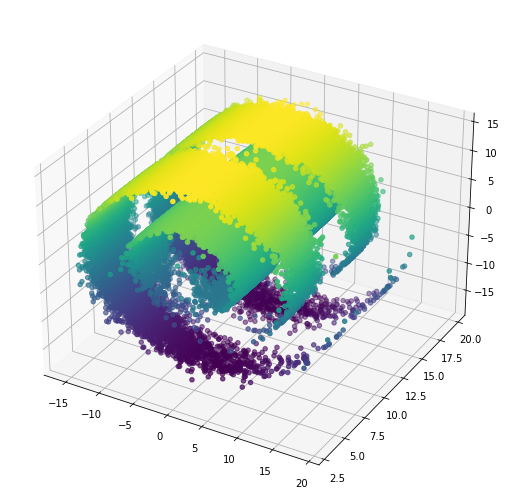

In [6]:
f = plt.figure(figsize=(16,9))
ax = f.add_subplot(111, projection='3d')
ax.scatter(data_x[:, 0], data_x[:, 1], data_x[:, 2], c=data_x[:, 2])
plt.show()

In [7]:
def whiten(x):
    x_mean = np.mean(x, axis=0)
    x_meanfree = (x - x_mean)
    C = (1 / (x.shape[0]-1)) * x_meanfree.T @ x_meanfree

    eigenvalues, W  = np.linalg.eigh(C)
    sig_inv = np.diag(1./np.sqrt(np.abs(eigenvalues) 
                                 + 1e-6))
    C_sqrt_inv = W @ sig_inv @ W.T

    whitened = x_meanfree @ C_sqrt_inv
    return whitened, x_mean, C_sqrt_inv

In [8]:
# whiten data
data_whitend, x_mean, C_sqrt_inv = whiten(data_x)
val_data_whitend = (validation_x - x_mean) @ C_sqrt_inv

In [9]:
data_whitend.var(axis=0)

array([0.99998998, 0.99998993, 0.99998998])

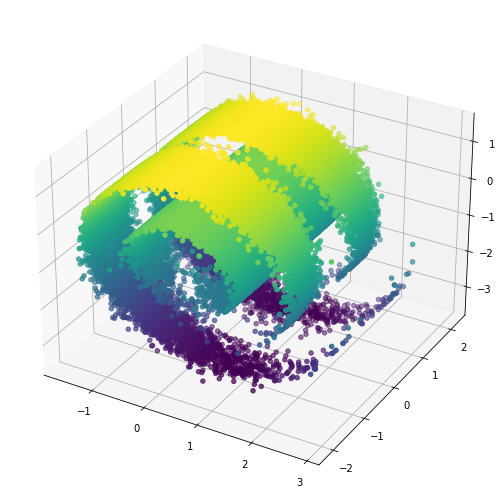

In [10]:
f = plt.figure(figsize=(16,9))
ax = f.add_subplot(111, projection='3d')
ax.scatter(data_whitend[:, 0], data_whitend[:, 1], data_whitend[:, 2], c=data_whitend[:, 2])
plt.show()

### Model

In [11]:
# Model
# implemented as in https://arxiv.org/pdf/1710.11239.pdf
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.e1 = torch.nn.Linear(3, 200)
        self.e2 = torch.nn.Linear(200, 100)
        self.e3 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.e1(x))
        x = F.leaky_relu(self.e2(x))
        x = self.e3(x)
        return x
    
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.e1 = torch.nn.Linear(1, 100)
        self.e2 = torch.nn.Linear(100, 200)
        self.e3 = torch.nn.Linear(200, 3)
        
    def forward(self, x):
        x = F.leaky_relu(self.e1(x))
        x = F.leaky_relu(self.e2(x))
        x = self.e3(x)
        return x
    
class Autoencoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

In [12]:
# Training
MSE = torch.nn.MSELoss()

def train(data, model, time_lag, learning_rate=1e-4, epochs=10, batch_size=512):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    val_acc = []
    
    inputs = torch.from_numpy(data[:-time_lag])
    targets = torch.from_numpy(data[time_lag:])
    train_ds = TensorDataset(inputs, targets)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    for epoch in tqdm(range(epochs)):
        for x, x_tau in train_dl:
            optimizer.zero_grad()
            output = model(x)
            loss = MSE(output, x_tau)
            loss.backward()
            optimizer.step()
            losses += [loss.detach()]
            
        # VALIDATE ON validation_x and validation_y
        
        latent_prediciton = model.encoder(torch.from_numpy(val_data_whitend)).detach()
        prediction = cluster(latent_prediciton)
        acc = accuracy(prediction, validation_y)
        val_acc += [acc]
    return losses, val_acc

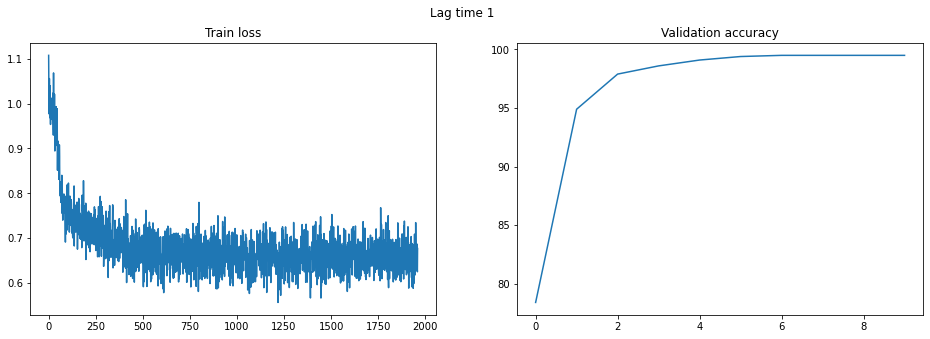

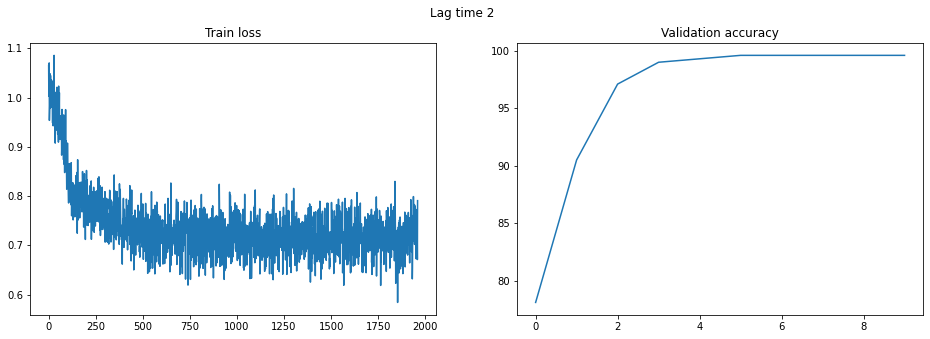

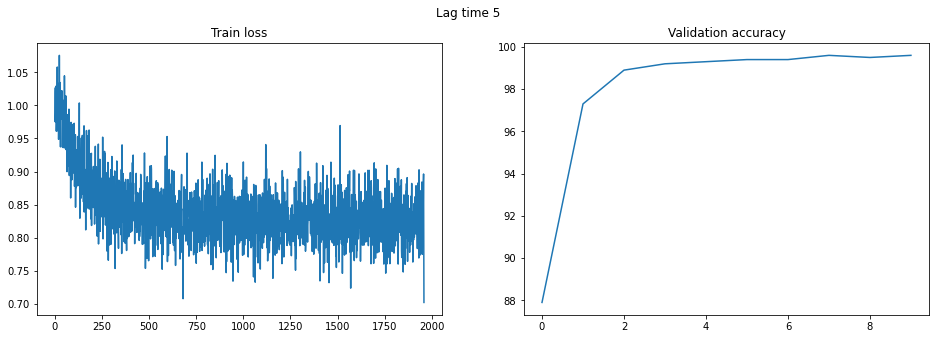

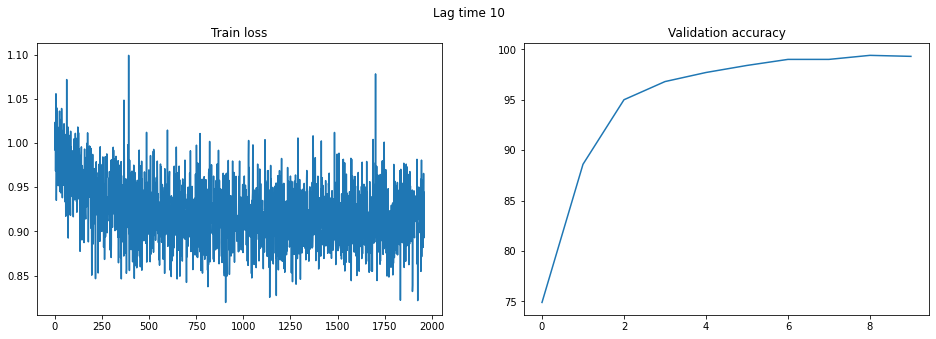

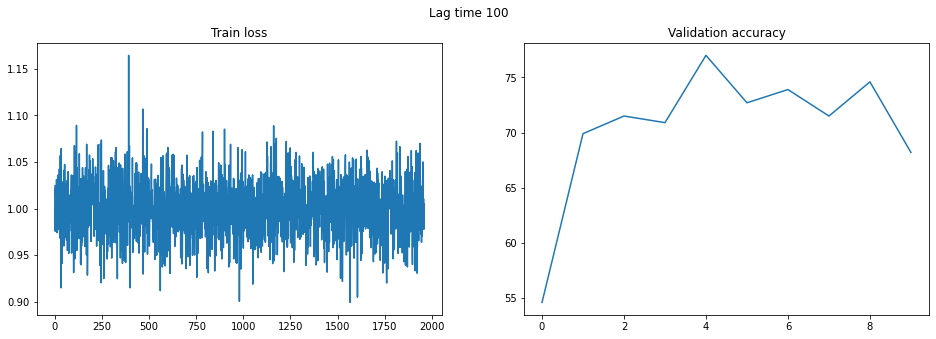


Best lag time is 2


In [13]:
# hyperparameter search
best_val_acc = 0
best_lag_time = -1

for lag_time in tqdm([1,2,5,10,100]):
    autoencoder = Autoencoder(Encoder(), Decoder())
    losses, val_acc = train(data_whitend, autoencoder, lag_time)
    
    # save best model
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_lag_time = lag_time
        torch.save(autoencoder.state_dict(), "best_model")
        
    # visualize losses    
    f, ax = plt.subplots(1,2, figsize=(16, 5))
    ax[0].plot(losses)
    ax[0].title.set_text("Train loss")
    ax[1].plot(val_acc)
    ax[1].title.set_text("Validation accuracy")

    f.suptitle(f'Lag time {lag_time}')
    plt.show()   

print(f"Best lag time is {best_lag_time}")

### Prediction

In [14]:
autoencoder = Autoencoder(Encoder(),Decoder())
autoencoder.load_state_dict(torch.load("best_model"))

<All keys matched successfully>

In [15]:
# PREDICT prediction FROM data_x

latent_prediciton = autoencoder.encoder(torch.from_numpy(data_whitend)).detach()
prediction = cluster(latent_prediciton)

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 100000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (100000, )
    assert loaded.dtype == int
    assert (loaded <= 3).all()
    assert (loaded >= 0).all()
validate_prediction_format()

Latent space encoding

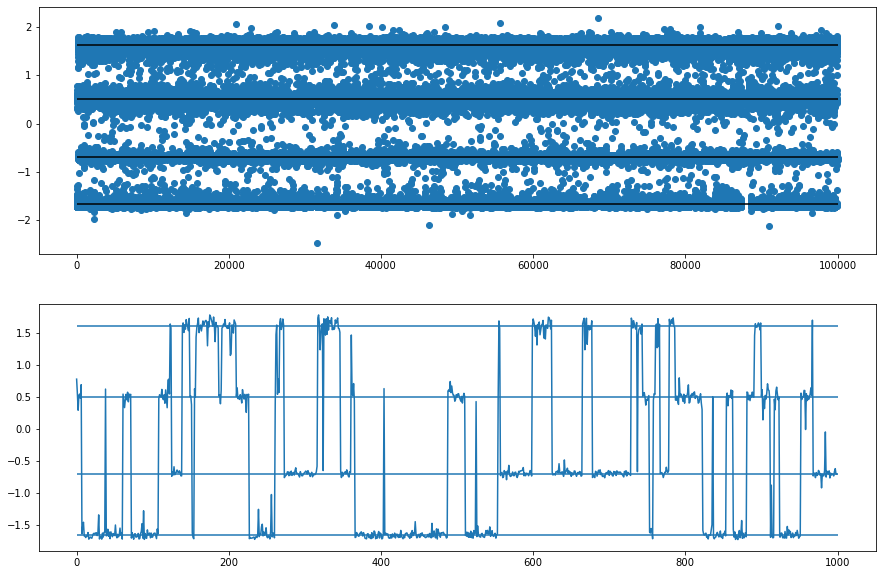

In [16]:
cc = KMeans(n_clusters=4).fit(latent_prediciton).cluster_centers_
f, ax = plt.subplots(2,1, figsize=(15, 10))
ax[0].scatter(np.arange(len(latent_prediciton)), latent_prediciton)
ax[0].hlines(cc, xmin=0, xmax=100000, color='black')
ax[1].plot(latent_prediciton[:1000])
ax[1].hlines(cc, xmin=0, xmax=1000)
plt.show()

In [29]:
yy = KMeans(n_clusters=4).fit(latent_prediciton).predict(latent_prediciton)

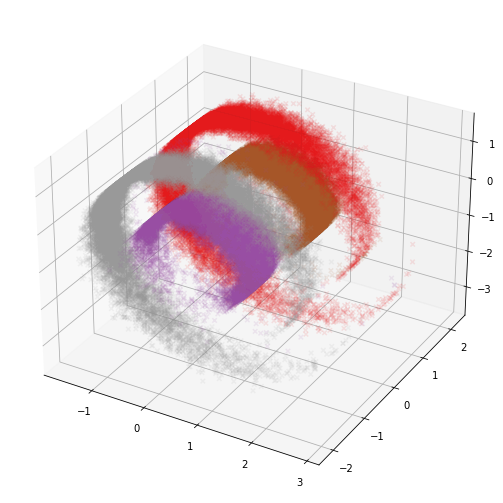

In [34]:
f = plt.figure(figsize=(16,9))
ax = f.add_subplot(111, projection='3d')
ax.scatter(data_whitend[:, 0], data_whitend[:, 1], data_whitend[:, 2], c=yy, cmap="Set1", alpha=0.1, marker="x")
plt.show()